# Process data for LED display

Scales and adjusts LED intensity values and converts to 'uint8'

In [1]:
import os
import csv
import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
image_dir = 'images'
data_dir = 'data'

label = 'seq_data'

In [3]:
#dt_string = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
filename = f'{label}_ids.csv'
with open(os.path.join(data_dir, filename), 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    lines = [line for line in csv_reader]

print("sequence data on file:")
sequences = []
for  line in lines:
    print(f"{line[0]}: {line[1]}")
    sequences.append(int(line[1]))

sequence data on file:
2022-01-01 22:16: 7
2022-01-01 22:16: 7
2022-01-01 22:17: 1
2022-01-01 22:25: 2
2022-01-01 22:31: 3
2022-01-01 22:37: 4
2022-01-01 22:43: 5
2022-01-01 23:52: 6
2022-01-02 00:00: 7
2022-01-02 00:03: 8
2022-01-02 00:05: 9
2022-01-02 00:07: 10
2022-01-02 00:10: 11
2022-01-02 00:12: 12
2022-01-02 00:15: 13
2022-01-02 00:19: 14
2022-01-02 00:21: 15
2022-01-02 00:24: 16
2022-01-02 00:26: 17
2022-01-02 00:30: 18
2022-01-02 00:33: 19
2022-01-02 00:35: 20
2022-01-02 00:37: 21
2022-01-02 00:40: 22
2022-01-02 00:43: 23
2022-01-02 00:47: 24
2022-01-02 00:49: 25
2022-01-02 00:51: 26
2022-01-02 00:55: 27
2022-01-02 00:58: 28
2022-01-02 01:00: 29
2022-01-02 01:04: 30
2022-01-02 01:06: 31
2022-01-02 01:09: 32
2022-01-02 01:11: 33
2022-01-02 01:14: 34
2022-01-02 01:16: 35
2022-01-02 01:19: 36
2022-01-02 01:22: 37
2022-01-02 01:25: 38
2022-01-02 01:28: 39
2022-01-02 01:33: 40
2022-01-02 01:35: 41
2022-01-02 01:37: 42
2022-01-02 01:39: 43
2022-01-02 01:41: 44
2022-01-02 01:44: 45
2

In [4]:
n_seq = len(np.unique(sequences))
n_seq

150

In [5]:
sequences[:10]

[7, 7, 1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
selected_seqs = list(range(1, 151))
n_seq_selected = len(selected_seqs)
n_seq_selected

150

In [7]:
import operator

def rindex(lst, value):
    """Find index of last occurrence of value in list.
    """
    return len(lst) - operator.indexOf(reversed(lst), value) - 1

assert(rindex(sequences, 7) == 8)

In [8]:
rgb_data = []
for c in range(3):
    filename = f'{label}_rgb_{c}.csv'
    with open(os.path.join(data_dir, filename), 'r') as f:
        x = np.loadtxt(f, delimiter=',')
    rgb_data.append(x)
assert(all(len(data) == len(sequences) for data in rgb_data))

In [9]:
# Adjustment parameters

adj_params = {
    'mul': [96, 96, 48],
    'power': [1, 1, 1],
    'div': [1, 1, 1],
    'v_min': [0, 0, 0],
    'v_max': [96, 96, 48]
}

rgb_data_adj = []
for c in range(3):
    mul = adj_params['mul'][c]
    div = adj_params['div'][c]
    power = adj_params['power'][c]
    v_min = adj_params['v_min'][c]
    v_max = adj_params['v_max'][c]
    x_data = []
    for seq in selected_seqs:
        i_seq = rindex(sequences, seq)
        x = np.clip(rgb_data[c][i_seq] * mul ** power / div, 
                    v_min, v_max)
        x = x.astype('uint8')
        x_data.append(x)
    rgb_data_adj.append(x_data)

len(rgb_data_adj)

3

## Find similar points in sequence

In [10]:
# Compare pairs of values

seq_data = np.array(rgb_data_adj).swapaxes(0, 1).reshape(n_seq_selected, -1)
seq_data.shape

(150, 258)

In [11]:
assert(np.array_equal(
    seq_data[0, :],
    np.array(rgb_data_adj)[:, 0, :].flatten()
))

In [12]:
# Compute similarity between two sets of values
def calc_differences(seq_data, i, j):
    return ((seq_data[i, :] - seq_data[j, :]) ** 2).mean(axis=-1)

calc_differences(seq_data, 1, 20)

37.58139534883721

In [13]:
ii, jj = np.indices([n_seq_selected, n_seq_selected])

In [14]:
calc_differences(seq_data, ii, jj).shape

(150, 150)

In [15]:
np.array_equal(
    calc_differences(seq_data, ii, jj),
    ((seq_data[ii, :] - seq_data[jj, :]) ** 2).mean(axis=-1)
)

True

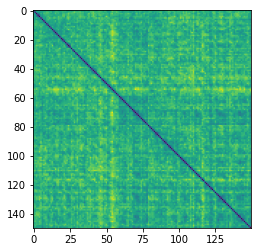

In [16]:
plt.imshow(calc_differences(seq_data, ii, jj))
plt.show()

In [17]:
diff_sorted = np.stack([calc_differences(seq_data, ii, jj), ii, jj], axis=2)
diff_sorted = diff_sorted.reshape(n_seq_selected**2, -1)
diff_sorted = diff_sorted[diff_sorted[:, 0].argsort(), :]
diff_sorted = diff_sorted.round(2)
# Drop self-comparisons
diff_sorted = diff_sorted[n_seq_selected:, :]
diff_sorted

array([[16.42,  4.  ,  3.  ],
       [16.42,  3.  ,  4.  ],
       [17.03, 24.  , 25.  ],
       ...,
       [54.45, 31.  , 54.  ],
       [56.92, 70.  , 54.  ],
       [56.92, 54.  , 70.  ]])

In [18]:
# Find biggest distance between matches
d = diff_sorted[:150]
np.hstack([d, np.abs(d[:, 2] - d[:, 1]).reshape(-1, 1)])

array([[ 16.42,   4.  ,   3.  ,   1.  ],
       [ 16.42,   3.  ,   4.  ,   1.  ],
       [ 17.03,  24.  ,  25.  ,   1.  ],
       [ 17.03,  25.  ,  24.  ,   1.  ],
       [ 17.17, 132.  , 131.  ,   1.  ],
       [ 17.17, 131.  , 132.  ,   1.  ],
       [ 17.72, 142.  , 141.  ,   1.  ],
       [ 17.72, 141.  , 142.  ,   1.  ],
       [ 18.07,  84.  ,  85.  ,   1.  ],
       [ 18.07,  85.  ,  84.  ,   1.  ],
       [ 18.43, 122.  , 123.  ,   1.  ],
       [ 18.43, 123.  , 122.  ,   1.  ],
       [ 19.47,  69.  ,  70.  ,   1.  ],
       [ 19.47,  70.  ,  69.  ,   1.  ],
       [ 19.63, 128.  , 129.  ,   1.  ],
       [ 19.63, 129.  , 128.  ,   1.  ],
       [ 19.63,  90.  ,  91.  ,   1.  ],
       [ 19.63,  91.  ,  90.  ,   1.  ],
       [ 20.05,  19.  ,  20.  ,   1.  ],
       [ 20.05,  20.  ,  19.  ,   1.  ],
       [ 20.38,  72.  ,  71.  ,   1.  ],
       [ 20.38,  71.  ,  72.  ,   1.  ],
       [ 20.48, 144.  , 143.  ,   1.  ],
       [ 20.48, 143.  , 144.  ,   1.  ],
       [ 20.58, 

In [19]:
# Good places to branch/loop sequence:
similar_seqs = [
    (127, 144),
    (69, 149),
    (72, 149),
    (70, 142),
    (78, 132)
]

## Print output

In [20]:
# Print output for insertion into fire_data.h file
selected_seqs = range(69, 149)  # 149 is similar to 69
print(f"{len(selected_seqs)} sequences")

# Calculate frame interval
fps = 25
print(f"Frame interval: {1000 / fps}")

for c in range(3):
    items = []
    print(f"\n// Data for {['R', 'G', 'B'][c]}\n")
    for seq, _ in enumerate(selected_seqs):
        data_to_strs = [f"{x:d}" for x in rgb_data_adj[c][seq].tolist()]
        items.append(', '.join(data_to_strs))
    print(',\n'.join(items))


80 sequences
Frame interval: 40.0

// Data for R

23, 50, 38, 32, 41, 71, 45, 56, 77, 64, 68, 43, 36, 34, 38, 28, 34, 44, 38, 58, 33, 20, 23, 28, 28, 22, 31, 37, 51, 26, 28, 18, 11, 20, 24, 24, 32, 13, 13, 21, 14, 24, 14, 33, 83, 68, 80, 61, 95, 95, 52, 62, 92, 23, 76, 74, 85, 65, 56, 79, 85, 72, 89, 93, 71, 23, 87, 94, 86, 64, 59, 78, 80, 92, 95, 93, 95, 64, 44, 59, 81, 81, 89, 67, 37, 23,
23, 50, 37, 29, 27, 23, 41, 70, 80, 23, 85, 58, 36, 34, 35, 23, 48, 52, 41, 29, 21, 21, 22, 23, 28, 23, 21, 60, 32, 25, 28, 18, 11, 20, 22, 23, 27, 20, 20, 21, 14, 19, 16, 34, 86, 74, 85, 64, 95, 95, 58, 63, 95, 23, 74, 79, 87, 63, 56, 77, 84, 70, 81, 92, 65, 54, 90, 93, 88, 65, 52, 89, 85, 92, 93, 89, 66, 23, 35, 48, 74, 82, 79, 79, 89, 23,
23, 51, 37, 29, 27, 23, 75, 78, 75, 64, 65, 52, 36, 33, 34, 23, 37, 23, 23, 30, 21, 21, 22, 23, 27, 21, 9, 49, 34, 34, 28, 18, 0, 21, 22, 23, 49, 39, 20, 21, 14, 19, 14, 33, 83, 72, 83, 64, 95, 95, 57, 57, 94, 89, 75, 78, 85, 60, 26, 79, 88, 69, 85, 89, 83, 23, 

In [21]:
# To insert black
print(', '.join([f"{x:d}" for x in [0]*86]))

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
